In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from spectres import spectres
from scipy.constants import c as speed_of_light
from tqdm import tqdm
import prodimopy.read as pread
from numba import njit
from scipy.stats import kendalltau, spearmanr, pearsonr
from scipy.signal import correlate, fftconvolve

In [3]:
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux

In [14]:
with open('FLiTsData1000.pkl', 'rb') as f:
    df = pickle.load(f)

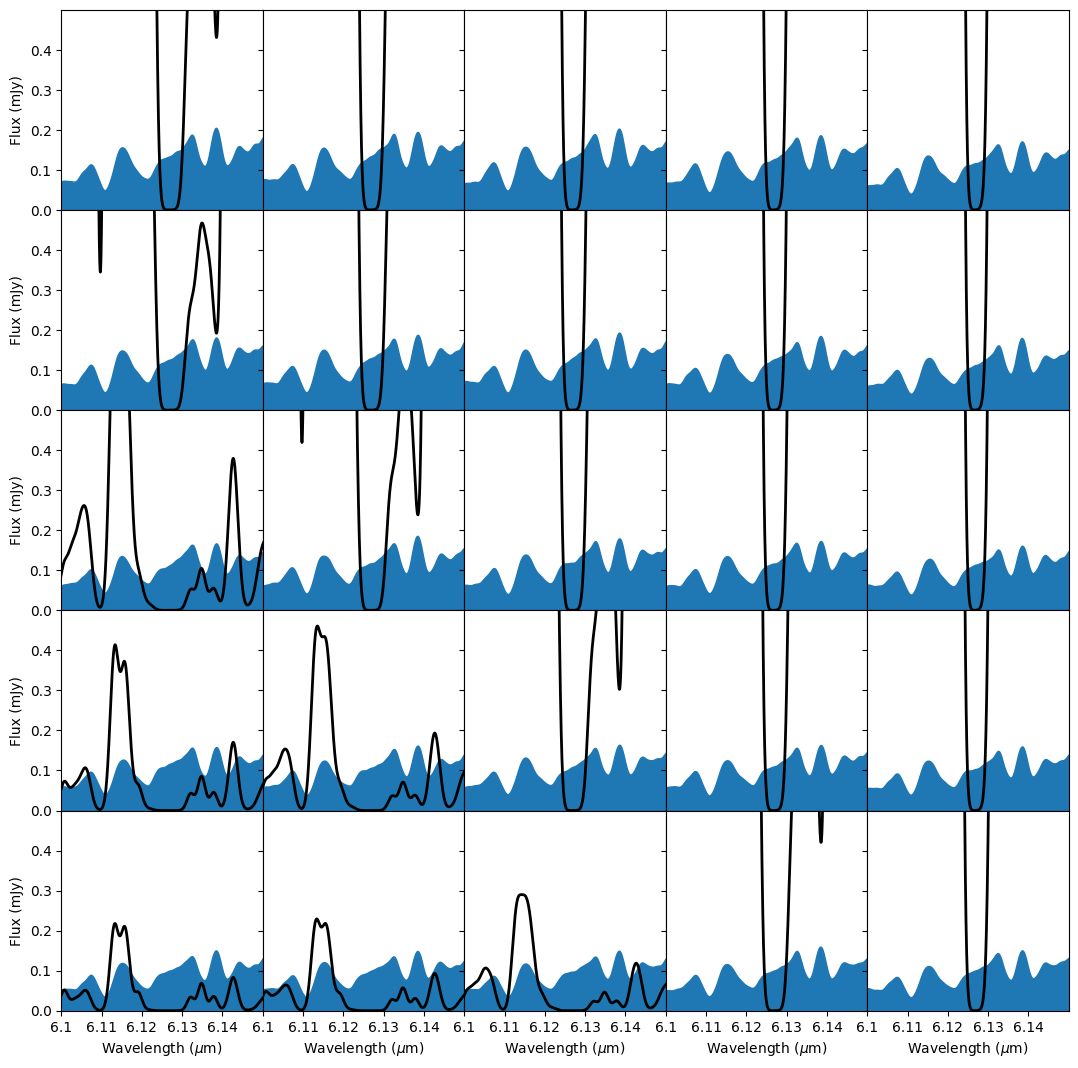

In [5]:
# %matplotlib notebook
plt.close('all')
total_spec = None
cmap = mpl.colormaps.get_cmap('tab20')
# fig, ax = plt.subplots(figsize=(14, 5))
species = ['C2H2','CH4', 'CO', 'CO2', 'H2O', 'HCN',  'NO', 'O2', 'OH','NH3']
# species = ['atomic', 'CH4',  'CO', 'CO2', 'HCN', 'NH3', 'NO', 'O2', 'OH']
species =['NH3']
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[6.1, 6.15]
yrange=[0,0.5]
num_xticks = 6
num_yticks = 6
for i in range(25):
    n_row, n_col = divmod(i, 5)
    total_spec = None
    # fig, ax = plt.subplots(figsize=(14, 5))
    model = df['Model Name'][i]
    FLiTs_wl = df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy()
    FLiTs_flux = df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy()
    for index, specie in enumerate(species):
        specie_wl = df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy()
        specie_flux = df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()
        new_specie_flux = np.interp(FLiTs_wl, specie_wl, specie_flux, left=0, right=0)
        if total_spec is None:
            total_spec = new_specie_flux
        else:
            total_spec += new_specie_flux
        axes[i].fill_between(FLiTs_wl, 0, total_spec*1000, label=specie, zorder=len(species) - index+1,
                        color=cmap(index / len(species)))
        # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
        # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
        # axes[i].plot(FLiTs_wl, new_specie_flux*1000)
    axes[i].plot(FLiTs_wl, FLiTs_flux*1000, c='black', lw=2, label='FLiTs', zorder=20)
    # ax.plot(specie_wl, specie_flux)
    # ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
    # fig.suptitle(model)
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_col == 0:
        axes[i].set_ylabel("Flux (mJy)")
        axes[i].set_yticks(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
        axes[i].set_yticklabels(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
    if n_row == 4:
        axes[i].set_xlabel(r"Wavelength ($\mu$m)")
        axes[i].set_xticks(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
        axes[i].set_xticklabels(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
plt.show()

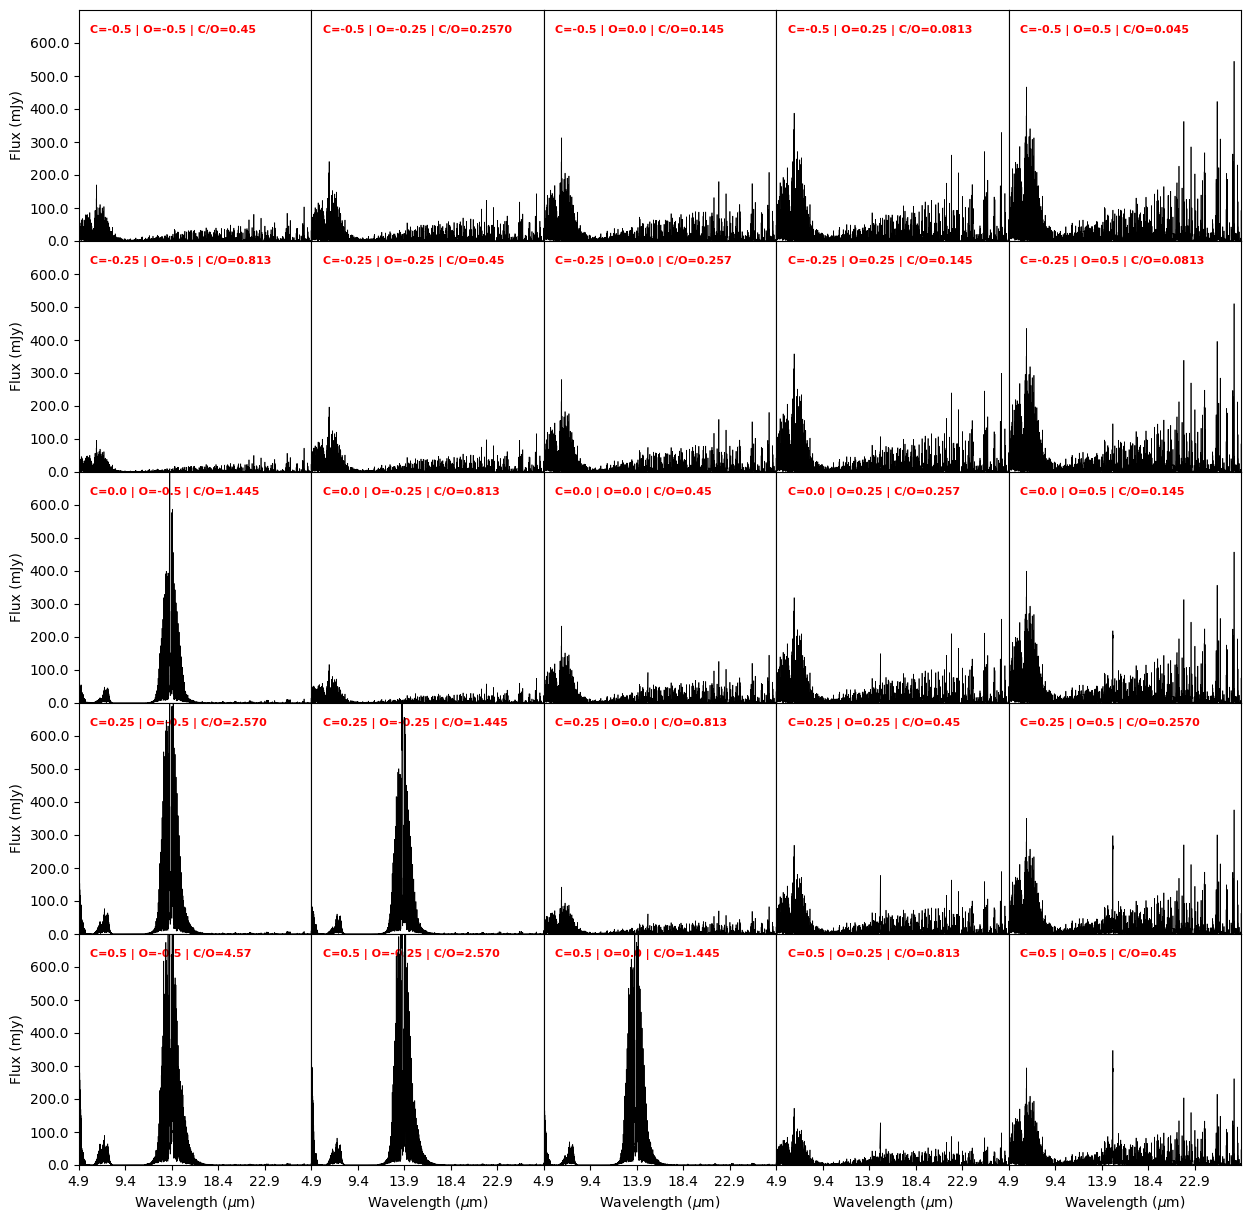

In [10]:
# %matplotlib notebook
plt.close('all')
total_spec = None
cmap = mpl.colormaps.get_cmap('tab20')
# fig, ax = plt.subplots(figsize=(14, 5))
species = ['C2H2','CH4', 'CO', 'CO2', 'H2O', 'HCN',  'NO', 'O2', 'OH','NH3']
# species = ['atomic', 'CH4',  'CO', 'CO2', 'HCN', 'NH3', 'NO', 'O2', 'OH']
species =['NH3']
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[4.9, 27.4]
yrange=[0,700]
num_xticks = 6
num_yticks = 8
for i in range(25):
    n_row, n_col = divmod(i, 5)
    total_spec = None
    # fig, ax = plt.subplots(figsize=(14, 5))
    model = df['Model Name'][i]
    FLiTs_wl = df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy()
    FLiTs_flux = df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy()
    # for index, specie in enumerate(species):
    #     specie_wl = df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy()
    #     specie_flux = df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()
    #     new_specie_flux = np.interp(FLiTs_wl, specie_wl, specie_flux, left=0, right=0)
    #     if total_spec is None:
    #         total_spec = new_specie_flux
    #     else:
    #         total_spec += new_specie_flux
    #     axes[i].fill_between(FLiTs_wl, 0, total_spec*1000, label=specie, zorder=len(species) - index+1,
    #                     color=cmap(index / len(species)))
        # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
        # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
        # axes[i].plot(FLiTs_wl, new_specie_flux*1000)
    axes[i].plot(FLiTs_wl, FLiTs_flux*1000, c='black', lw=.5, label='FLiTs', zorder=20, rasterized=True)
    # ax.plot(specie_wl, specie_flux)
    # ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
    # fig.suptitle(model)
    axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.05, yrange[0] + (yrange[1] - yrange[0]) * 0.9,f'C={df.loc[df['Model Name'] == model, 'C Value'].values[0]} | O={df.loc[df['Model Name'] == model, 'O Value'].values[0]} | C/O={df.loc[df['Model Name'] == model, 'CO Value'].values[0]}', fontsize=8, color='red',weight='bold')
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_col == 0:
        axes[i].set_ylabel("Flux (mJy)")
        axes[i].set_yticks(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
        axes[i].set_yticklabels(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
    else:
        axes[i].tick_params(labelleft=False, left=False)
    if n_row == 4:
        axes[i].set_xlabel(r"Wavelength ($\mu$m)")
        axes[i].set_xticks(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
        axes[i].set_xticklabels(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
    else:
        axes[i].tick_params(labelbottom=False, bottom=False)
plt.savefig('Figures/All_spectra.pdf', bbox_inches='tight')
plt.show()

6.125, 11.8

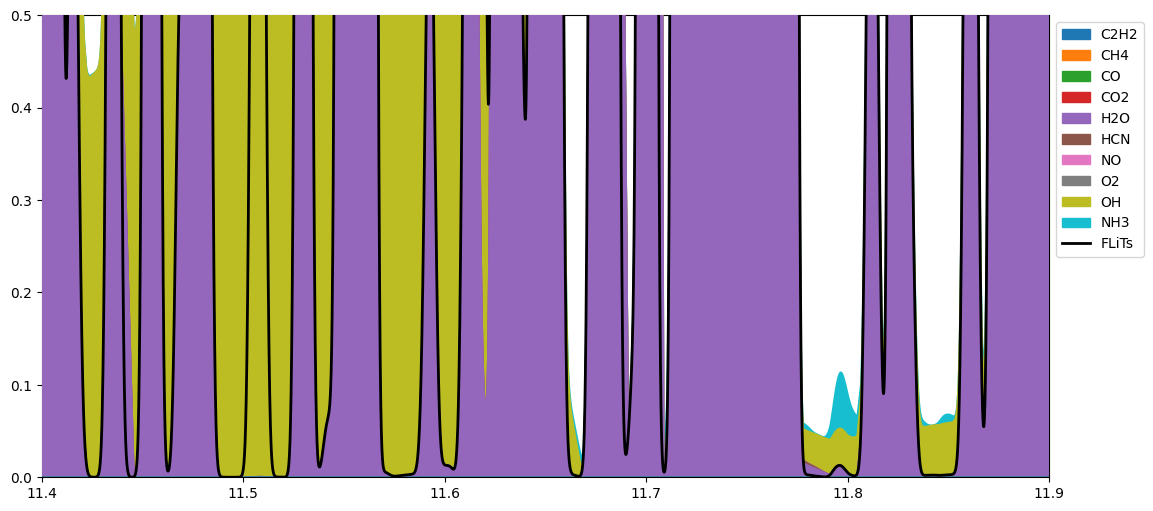

In [7]:
fig, ax = plt.subplots(figsize=(13, 6))
total_spec = None
cmap = mpl.colormaps.get_cmap('tab20')
# fig, ax = plt.subplots(figsize=(14, 5))
model = df['Model Name'][4]
FLiTs_wl = df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy()
FLiTs_flux = df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy()
species = ['C2H2','CH4', 'CO', 'CO2', 'H2O', 'HCN',  'NO', 'O2', 'OH','NH3']
# species = ['NH3']
xrange=[11.4, 11.9]
yrange=[0,0.5]
for index, specie in enumerate(species):
    specie_wl = df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy()
    specie_flux = df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()
    new_specie_flux = np.interp(FLiTs_wl, specie_wl, specie_flux, left=0, right=0)
    if total_spec is None:
        total_spec = new_specie_flux
    else:
        total_spec += new_specie_flux
    ax.fill_between(FLiTs_wl, 0, total_spec*1000, label=specie, zorder=len(species) - index+1,
                    color=cmap(index / len(species)))
    # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
    #                 color=cmap(index / len(species)))
    # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
    # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
    # axes[i].plot(FLiTs_wl, new_specie_flux*1000)
ax.plot(FLiTs_wl, FLiTs_flux*1000, c='black', lw=2, label='FLiTs', zorder=20)
# ax.plot(specie_wl, specie_flux)
# ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
# fig.suptitle(model)
ax.set_xlim(xrange)
ax.set_ylim(yrange)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

        atomic   CH4    CO   CO2   H2O   HCN   NH3    NO    O2    OH
atomic    1.00  0.06  0.32 -0.24 -0.04  0.15 -0.04 -0.07 -0.11 -0.07
CH4       0.06  1.00  0.02 -0.47 -0.75  0.74 -0.67 -0.83 -0.68 -0.89
CO        0.32  0.02  1.00 -0.21  0.00  0.05 -0.24  0.01  0.06  0.04
CO2      -0.24 -0.47 -0.21  1.00  0.64 -0.73  0.17  0.57  0.67  0.55
H2O      -0.04 -0.75  0.00  0.64  1.00 -0.88  0.47  0.89  0.81  0.84
HCN       0.15  0.74  0.05 -0.73 -0.88  1.00 -0.41 -0.84 -0.90 -0.81
NH3      -0.04 -0.67 -0.24  0.17  0.47 -0.41  1.00  0.53  0.36  0.60
NO       -0.07 -0.83  0.01  0.57  0.89 -0.84  0.53  1.00  0.79  0.92
O2       -0.11 -0.68  0.06  0.67  0.81 -0.90  0.36  0.79  1.00  0.76
OH       -0.07 -0.89  0.04  0.55  0.84 -0.81  0.60  0.92  0.76  1.00


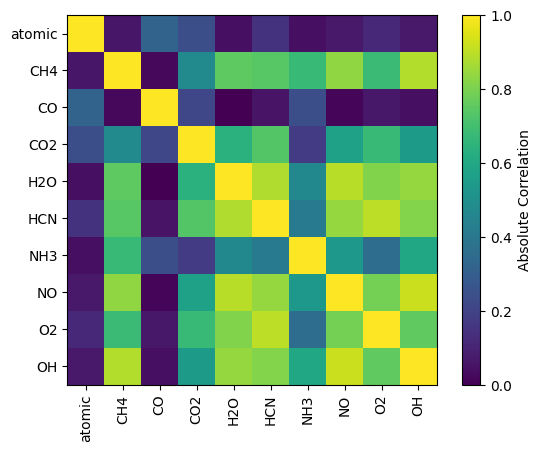

In [15]:
data = []
species = ['atomic', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux']))
    data.append(fluxes)
df_FLiTs_flux = pd.DataFrame(data, columns=species)
print(df_FLiTs_flux.corr(method='kendall').round(2))
plt.imshow(abs(df_FLiTs_flux.corr(method='kendall')), cmap=plt.get_cmap("viridis")) # method='kendall'
plt.xticks(ticks=np.arange(len(species)), labels=species, rotation=90)
plt.yticks(ticks=np.arange(len(species)), labels=species)
plt.colorbar(label='Absolute Correlation')
plt.show()

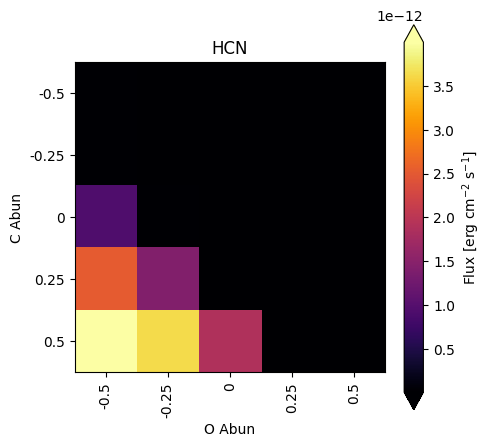

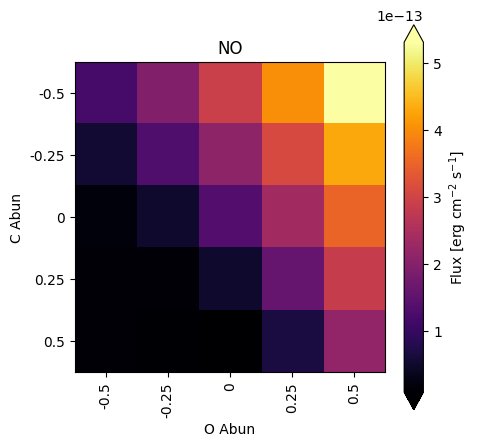

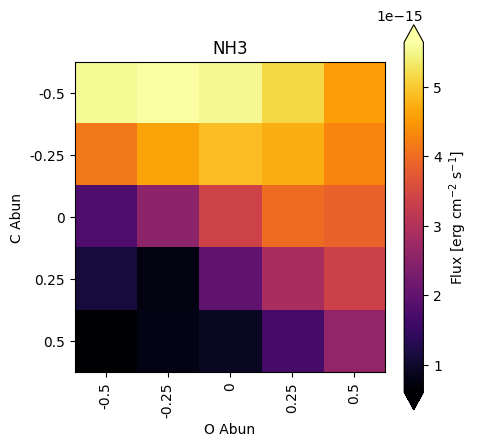

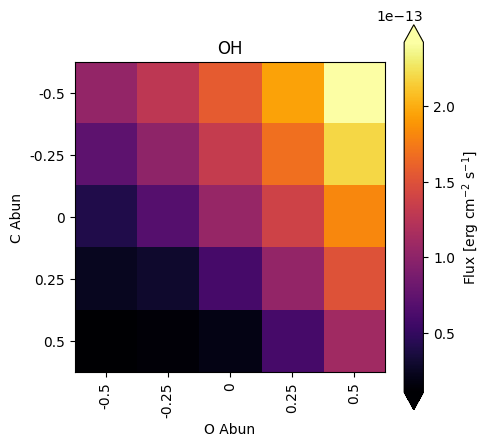

In [16]:

for specie in ['HCN', 'NO', 'NH3', 'OH']:
    plt.figure(figsize=(5, 5))
    plt.imshow(df_FLiTs_flux[specie].values.reshape(5,5), cmap='inferno')
    plt.title(specie)
    plt.xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    plt.yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
    plt.xlabel('O Abun')
    plt.ylabel('C Abun')
    plt.colorbar(label='Flux [erg cm$^{-2}$ s$^{-1}$]', extend='both')
    plt.savefig(f'Figures/{specie}_heatmap.pdf', bbox_inches='tight')
    plt.show()

In [10]:
for index, specie_1 in enumerate(species):
    for specie_2 in species[index+1:]:
        df_FLiTs_flux[f'{specie_1}/{specie_2}'] =df_FLiTs_flux[specie_1]/df_FLiTs_flux[specie_2]
df_FLiTs_flux['C Abun'] = df['C Value'].astype(float)
df_FLiTs_flux['O Abun'] = df['O Value'].astype(float)
df_FLiTs_flux['C/O Ratio'] = df['CO Value'].astype(float)
print(df_FLiTs_flux.corr().round(2))
# plt.imshow(abs(df_FLiTs_flux.corr()), cmap=plt.get_cmap("viridis")) # method='kendall'
# plt.xticks(ticks=np.arange(len(df_FLiTs_flux.columns)), labels=df_FLiTs_flux.columns, rotation=90)
# plt.yticks(ticks=np.arange(len(df_FLiTs_flux.columns)), labels=df_FLiTs_flux.columns)
# plt.colorbar(label='Absolute Correlation')
# plt.show()

            atomic   CH4    CO   CO2   H2O   HCN   NH3    NO    O2    OH  ...  \
atomic        1.00  0.44  0.75 -0.29 -0.15  0.70 -0.31 -0.01  0.21 -0.09  ...   
CH4           0.44  1.00  0.81 -0.45 -0.68  0.81 -0.76 -0.59 -0.33 -0.65  ...   
CO            0.75  0.81  1.00 -0.31 -0.45  0.96 -0.70 -0.35 -0.09 -0.43  ...   
CO2          -0.29 -0.45 -0.31  1.00  0.54 -0.38  0.05  0.35  0.50  0.46  ...   
H2O          -0.15 -0.68 -0.45  0.54  1.00 -0.65  0.69  0.95  0.80  0.99  ...   
HCN           0.70  0.81  0.96 -0.38 -0.65  1.00 -0.79 -0.56 -0.30 -0.63  ...   
NH3          -0.31 -0.76 -0.70  0.05  0.69 -0.79  1.00  0.73  0.27  0.72  ...   
NO           -0.01 -0.59 -0.35  0.35  0.95 -0.56  0.73  1.00  0.80  0.98  ...   
O2            0.21 -0.33 -0.09  0.50  0.80 -0.30  0.27  0.80  1.00  0.83  ...   
OH           -0.09 -0.65 -0.43  0.46  0.99 -0.63  0.72  0.98  0.83  1.00  ...   
atomic/CH4    0.02 -0.15 -0.09 -0.32  0.28 -0.17  0.37  0.28  0.17  0.28  ...   
atomic/CO    -0.43 -0.72 -0.

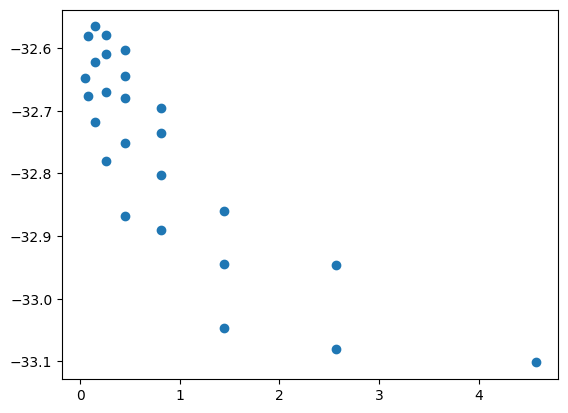

In [11]:
plt.scatter(df_FLiTs_flux['C/O Ratio'], np.log(df_FLiTs_flux['NH3']))
plt.show()

READ: Reading File:  gdr_1000_N/C_-0.5_O_-0.5_CO_0.45\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_-0.25_CO_0.2570\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.0_CO_0.145\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.25_CO_0.0813\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.5_CO_0.045\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.25_O_-0.5_CO_0.813\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.25_O_-0.25_CO_0.45\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.25_O_0.0_CO_0.257\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.25_O_0.25_CO_0.145\specFLiTs1_NH3.out  ...
INFO: 

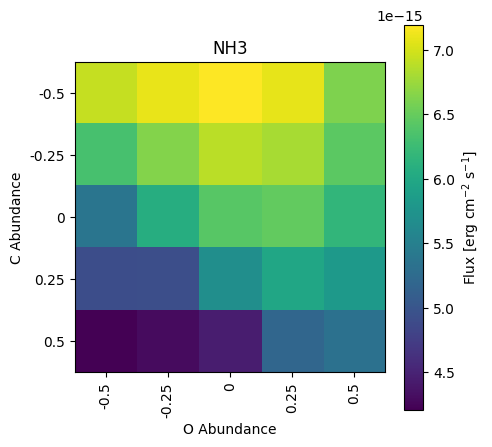

In [12]:
specie = 'NH3'
total = []
for model in df['Model Name']:
    specie_flits = pread.read_FLiTs(f'gdr_1000_N/{model}', filename=f'specFLiTs1_{specie}.out')
    wl, flux, flux_cont = specie_flits.convolve(3000, contReturn=True)
    flux -= flux_cont
    total.append(total_flux(wl, flux))
    # plt.plot(wl, flux)
    # plt.title(total[-1])
    # plt.show()
plt.figure(figsize=(5, 5))
plt.imshow(np.asarray(total).reshape(5,5), cmap='viridis')
plt.title(specie)
plt.xticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
plt.yticks(ticks=np.arange(5), labels=[-0.5, -0.25, 0, 0.25, 0.5])
plt.xlabel('O Abundance')
plt.ylabel('C Abundance')
plt.colorbar(label='Flux [erg cm$^{-2}$ s$^{-1}$]')
plt.savefig(f'Flux_{specie}.png')
plt.show()

READ: Reading File:  gdr_1000_N/C_-0.5_O_0.0_CO_0.145\specFLiTs1.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.0_CO_0.145\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 


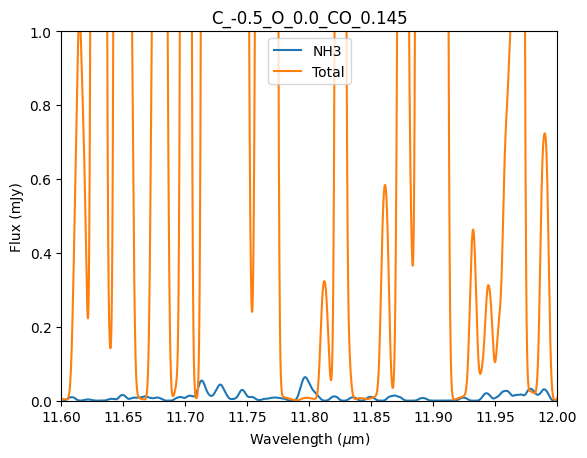

In [13]:
model_index = 2
total_flits = pread.read_FLiTs(f'gdr_1000_N/{df['Model Name'][model_index]}', filename=f'specFLiTs1.out')
total_wl, tot_flux, total_flux_cont = total_flits.convolve(3000, contReturn=True)
tot_flux -= total_flux_cont
NH3_flits = pread.read_FLiTs(f'gdr_1000_N/{df['Model Name'][model_index]}', filename=f'specFLiTs1_NH3.out')
NH3_wl, NH3_flux, NH3_flux_cont = NH3_flits.convolve(3000, contReturn=True)
NH3_flux -= NH3_flux_cont
plt.plot(NH3_wl, NH3_flux*1000, label='NH3')
plt.plot(total_wl, tot_flux*1000, label='Total')
# plt.xlim(5, 7)
plt.xlim(11.6, 12)
plt.ylim(0,1)
plt.title(df['Model Name'][model_index])
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Flux (mJy)')
plt.legend()
plt.show()

READ: Reading File:  gdr_1000_N/C_0.25_O_-0.5_CO_2.570\specFLiTs1.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_0.25_O_-0.5_CO_2.570\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 


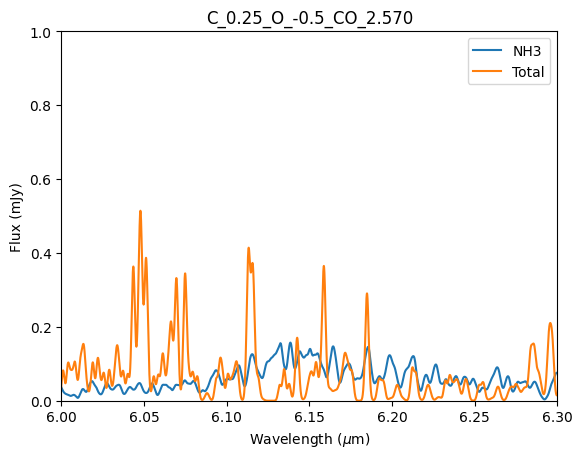

In [14]:
model_index = 15
total_flits = pread.read_FLiTs(f'gdr_1000_N/{df['Model Name'][model_index]}', filename=f'specFLiTs1.out')
total_wl, tot_flux, total_flux_cont = total_flits.convolve(3000, contReturn=True)
tot_flux -= total_flux_cont
NH3_flits = pread.read_FLiTs(f'gdr_1000_N/{df['Model Name'][model_index]}', filename=f'specFLiTs1_NH3.out')
NH3_wl, NH3_flux, NH3_flux_cont = NH3_flits.convolve(3000, contReturn=True)
NH3_flux -= NH3_flux_cont
plt.plot(NH3_wl, NH3_flux*1000, label='NH3')
plt.plot(total_wl, tot_flux*1000, label='Total')
plt.xlim(6, 6.3)
# plt.xlim(11.6, 12)
plt.ylim(0,1)
plt.title(df['Model Name'][model_index])
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Flux (mJy)')
plt.legend()
plt.show()

READ: Reading File:  gdr_1000_N/C_-0.5_O_-0.5_CO_0.45\specFLiTs1.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_-0.5_CO_0.45\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_-0.25_CO_0.2570\specFLiTs1.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_-0.25_CO_0.2570\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.0_CO_0.145\specFLiTs1.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.0_CO_0.145\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.25_CO_0.0813\specFLiTs1.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.25_CO_0.0813\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.5_CO_0.045\specFLiTs1.out  ...
INFO: convolve FLiTs spectru

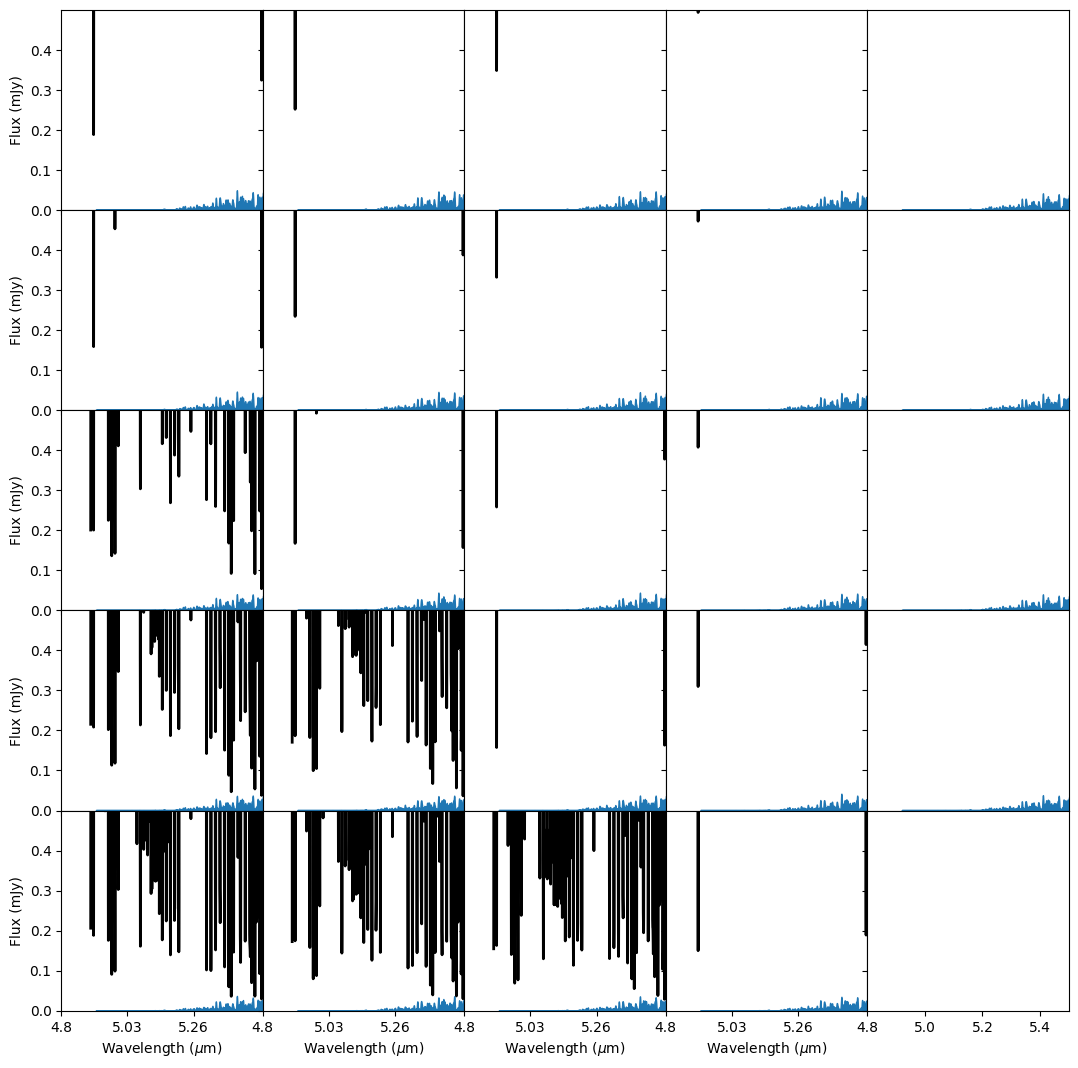

In [16]:
species = ['NO']
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[4.8, 7]
yrange=[0,0.5]
num_xticks = 4
num_yticks = 6
total_spec= None
for model_index in range(24):
    n_row, n_col = divmod(model_index, 5)
    total_spec = None
    # fig, ax = plt.subplots(figsize=(14, 5))
    total_flits = pread.read_FLiTs(f'gdr_1000_N/{df['Model Name'][model_index]}', filename=f'specFLiTs1.out')
    total_wl, tot_flux, total_flux_cont = total_flits.convolve(3000, contReturn=True)
    tot_flux -= total_flux_cont
    for index, specie in enumerate(species):
        NH3_flits = pread.read_FLiTs(f'gdr_1000_N/{df['Model Name'][model_index]}', filename=f'specFLiTs1_NH3.out')
        NH3_wl, NH3_flux, NH3_flux_cont = NH3_flits.convolve(3000, contReturn=True)
        NH3_flux -= NH3_flux_cont
        # new_specie_flux = np.interp(total_wl, NH3_wl, NH3_flux, left=0, right=0)
        # if total_spec is None:
        #     total_spec = new_specie_flux
        # else:
        #     total_spec += new_specie_flux
        axes[model_index].fill_between(NH3_wl, 0, NH3_flux*1000, label=specie, zorder=len(species) - index+1,
                        color=cmap(index / len(species)))
        # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
        # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
        # axes[i].plot(FLiTs_wl, new_specie_flux*1000)
    axes[model_index].plot(total_wl, tot_flux*1000, c='black', lw=2, label='FLiTs', zorder=20)
    # ax.plot(specie_wl, specie_flux)
    # ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
    # fig.suptitle(model)
    axes[model_index].set_xlim(xrange)
    axes[model_index].set_ylim(yrange)
    if n_col == 0:
        axes[model_index].set_ylabel("Flux (mJy)")
        axes[model_index].set_yticks(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
        axes[model_index].set_yticklabels(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
    if n_row == 4:
        axes[model_index].set_xlabel(r"Wavelength ($\mu$m)")
        axes[model_index].set_xticks(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
        axes[model_index].set_xticklabels(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
# plt.legend()
plt.show()

READ: Reading File:  gdr_1000_N/C_-0.5_O_-0.5_CO_0.45\specFLiTs1.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_-0.5_CO_0.45\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_-0.25_CO_0.2570\specFLiTs1.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_-0.25_CO_0.2570\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.0_CO_0.145\specFLiTs1.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.0_CO_0.145\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.25_CO_0.0813\specFLiTs1.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.25_CO_0.0813\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.5_CO_0.045\specFLiTs1.out  ...
INFO: convolve FLiTs spectru

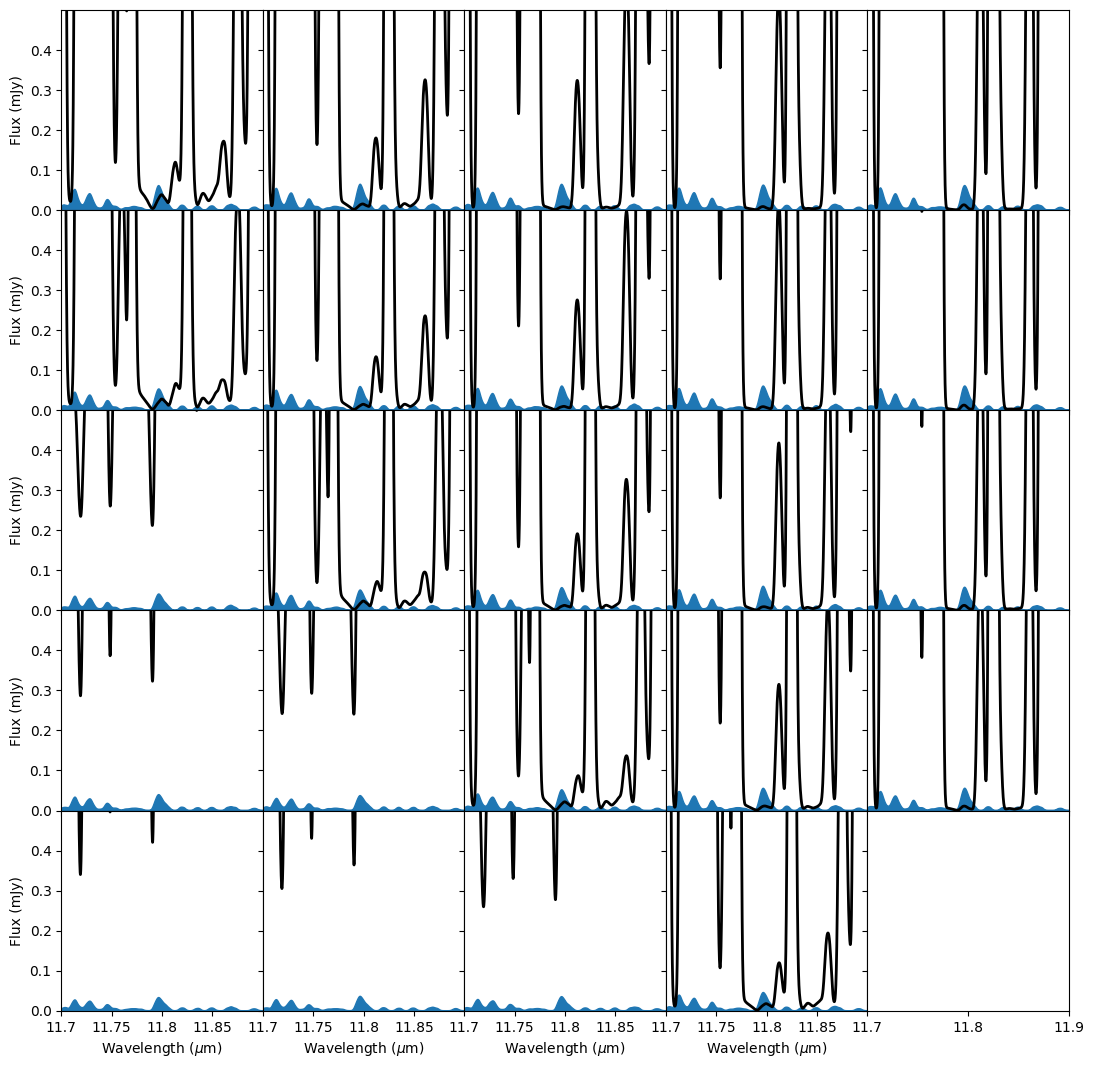

In [15]:
species =['NH3']
fig = plt.figure(figsize=(13, 13))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[11.7, 11.9]
yrange=[0,0.5]
num_xticks = 5
num_yticks = 6
total_spec= None
for model_index in range(24):
    n_row, n_col = divmod(model_index, 5)
    total_spec = None
    # fig, ax = plt.subplots(figsize=(14, 5))
    total_flits = pread.read_FLiTs(f'gdr_1000_N/{df['Model Name'][model_index]}', filename=f'specFLiTs1.out')
    total_wl, tot_flux, total_flux_cont = total_flits.convolve(3000, contReturn=True)
    tot_flux -= total_flux_cont
    for index, specie in enumerate(species):
        NH3_flits = pread.read_FLiTs(f'gdr_1000_N/{df['Model Name'][model_index]}', filename=f'specFLiTs1_NH3.out')
        NH3_wl, NH3_flux, NH3_flux_cont = NH3_flits.convolve(3000, contReturn=True)
        NH3_flux -= NH3_flux_cont
        # new_specie_flux = np.interp(total_wl, NH3_wl, NH3_flux, left=0, right=0)
        # if total_spec is None:
        #     total_spec = new_specie_flux
        # else:
        #     total_spec += new_specie_flux
        axes[model_index].fill_between(NH3_wl, 0, NH3_flux*1000, label=specie, zorder=len(species) - index+1,
                        color=cmap(index / len(species)))
        # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
        # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
        # axes[i].plot(FLiTs_wl, new_specie_flux*1000)
    axes[model_index].plot(total_wl, tot_flux*1000, c='black', lw=2, label='FLiTs', zorder=20)
    # ax.plot(specie_wl, specie_flux)
    # ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
    # fig.suptitle(model)
    axes[model_index].set_xlim(xrange)
    axes[model_index].set_ylim(yrange)
    if n_col == 0:
        axes[model_index].set_ylabel("Flux (mJy)")
        axes[model_index].set_yticks(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
        axes[model_index].set_yticklabels(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
    if n_row == 4:
        axes[model_index].set_xlabel(r"Wavelength ($\mu$m)")
        axes[model_index].set_xticks(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
        axes[model_index].set_xticklabels(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
# plt.legend()
plt.show()

READ: Reading File:  gdr_1000_N/C_-0.5_O_0.5_CO_0.045\specFLiTs1.out  ...
INFO: convolve FLiTs spectrum ... 
READ: Reading File:  gdr_1000_N/C_-0.5_O_0.5_CO_0.045\specFLiTs1_NH3.out  ...
INFO: convolve FLiTs spectrum ... 


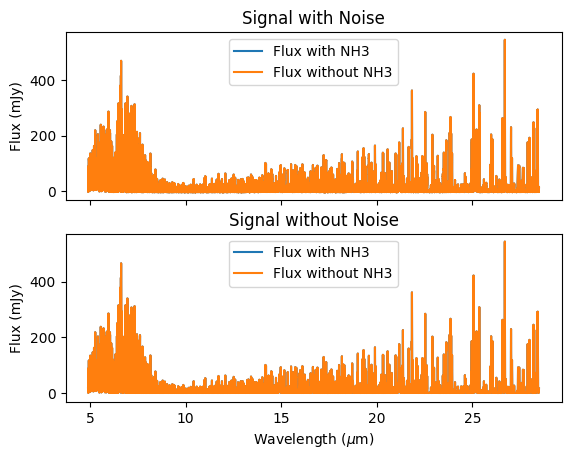

In [340]:

def add_noise(flux, SNR):
    """
    SNR = flux/sigma
    """
    noise_level = np.min(flux) / SNR
    noise = np.random.normal(0, noise_level, size=flux.shape)
    return flux + noise


model_index = 4
model_flits = pread.read_FLiTs('gdr_1000_N/' + df['Model Name'][model_index], filename='specFLiTs1.out')
wl, flux, flux_cont = model_flits.convolve(3000, contReturn=True)

NH3_flits = pread.read_FLiTs(f'gdr_1000_N/{df['Model Name'][model_index]}', filename=f'specFLiTs1_NH3.out')
NH3_wl, NH3_flux, NH3_flux_cont = NH3_flits.convolve(3000, contReturn=True)
NH3_flux = np.interp(wl, NH3_wl, NH3_flux)
NH3_flux_cont = np.interp(wl, NH3_wl, NH3_flux_cont)
total_flux = flux + NH3_flux - NH3_flux_cont

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
np.random.seed(42)
noise_flux = add_noise(total_flux, 300)
ax1.plot(wl, (noise_flux - flux_cont) * 1000, label='Flux with NH3')
np.random.seed(42)
noise_flux = add_noise(flux, 300)
ax1.plot(wl, (noise_flux - flux_cont) * 1000, label='Flux without NH3')
ax1.set_title('Signal with Noise')
ax1.set_ylabel('Flux (mJy)')
# ax1.set_xlim(6, 6.3)
# ax1.set_ylim(0, 5)
ax1.legend()
ax2.plot(wl, (total_flux - flux_cont) * 1000, label='Flux with NH3')
ax2.plot(wl, (flux - flux_cont) * 1000, label='Flux without NH3')
ax2.set_title('Signal without Noise')
ax2.set_xlabel(R'Wavelength ($\mu$m)')
ax2.set_ylabel('Flux (mJy)')
ax2.legend()
plt.show()

In [74]:
print(np.random.randint(1000))

463


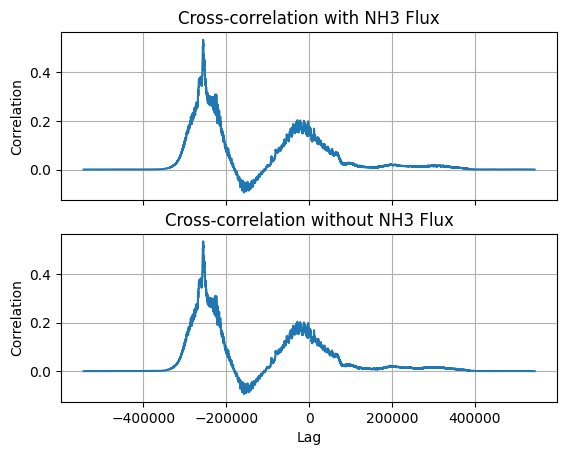

In [138]:
random_number = np.random.randint(1000)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

np.random.seed(random_number)
noise_flux = add_noise(total_flux, 300)
cc1 = fftconvolve((NH3_flux - NH3_flux_cont), (noise_flux - flux_cont)[::-1], mode='full')
lags = np.arange(-len(noise_flux)+1, len(NH3_flux))
ax1.plot(lags, cc1)
ax1.set_title("Cross-correlation with NH3 Flux")
ax1.set_ylabel("Correlation")
ax1.grid(True)


np.random.seed(random_number)
noise_flux = add_noise(flux, 300)
cc2 = fftconvolve((NH3_flux - NH3_flux_cont), (noise_flux - flux_cont)[::-1], mode='full')
lags = np.arange(-len(noise_flux)+1, len(NH3_flux))
ax2.plot(lags, cc2)
ax2.set_title("Cross-correlation without NH3 Flux")
ax2.set_xlabel("Lag")
ax2.set_ylabel("Correlation")
ax2.grid(True)
plt.show()

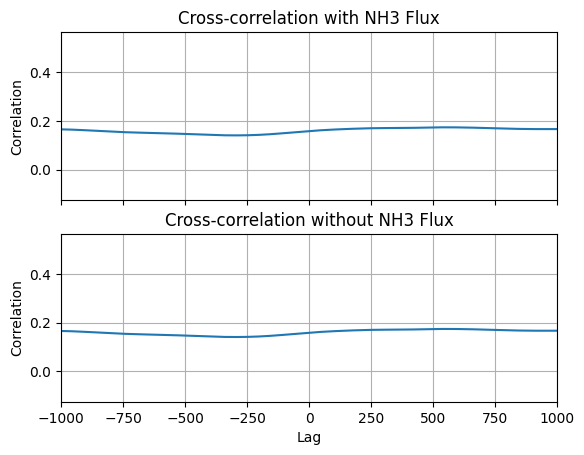

In [140]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

ax1.plot(lags, cc1)
ax1.set_title("Cross-correlation with NH3 Flux")
ax1.set_ylabel("Correlation")
ax1.grid(True)
ax1.set_xlim(-1000, 1000)

ax2.plot(lags, cc2)
ax2.set_title("Cross-correlation without NH3 Flux")
ax2.set_xlabel("Lag")
ax2.set_ylabel("Correlation")
ax2.grid(True)
plt.show()

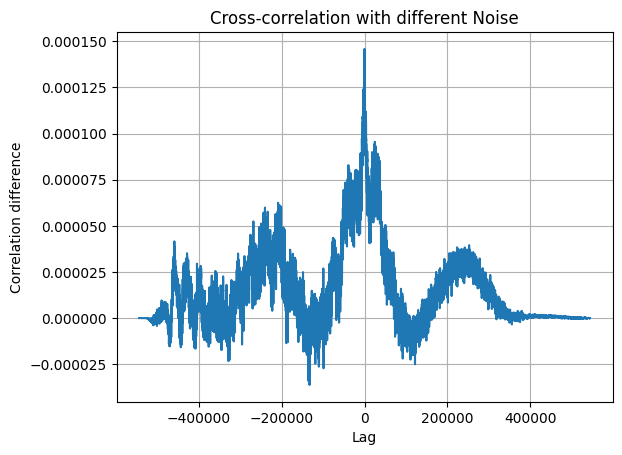

In [265]:
plt.plot(lags, cc1-cc2)
plt.title("Cross-correlation with different Noise")
plt.xlabel("Lag")
plt.ylabel("Correlation difference")
plt.grid(True)
# plt.xlim(-100000, 100000)
plt.show()

In [341]:
wl_uniform = np.linspace(min(wl), max(wl), len(wl))
flux_wout_NH3_uniform = np.interp(wl_uniform, wl, flux)
total_flux_uniform = np.interp(wl_uniform, wl, total_flux)
flux_cont_uniform = np.interp(wl_uniform, wl, flux_cont)
np.random.seed(42)
noise_flux_uniform = add_noise(total_flux_uniform, 300)
NH3_flux_uniform = np.interp(wl_uniform, wl, NH3_flux)
NH3_flux_cont_uniform = np.interp(wl_uniform, wl, NH3_flux_cont)
np.random.seed(42)
noise_flux_wout_NH3_uniform = add_noise(flux_wout_NH3_uniform, 300)

# Continuum subtract
NH3_flux_uniform -= NH3_flux_cont_uniform
noise_flux_uniform -= flux_cont_uniform
noise_flux_wout_NH3_uniform -= flux_cont_uniform

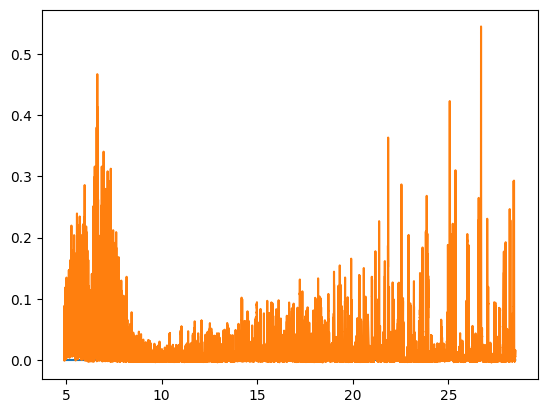

In [379]:
plt.plot(wl_uniform, NH3_flux_uniform)
plt.plot(wl_uniform, noise_flux_uniform)
# plt.xlim(19.75, 20.25)
# plt.ylim(0, 0.01)
plt.show()

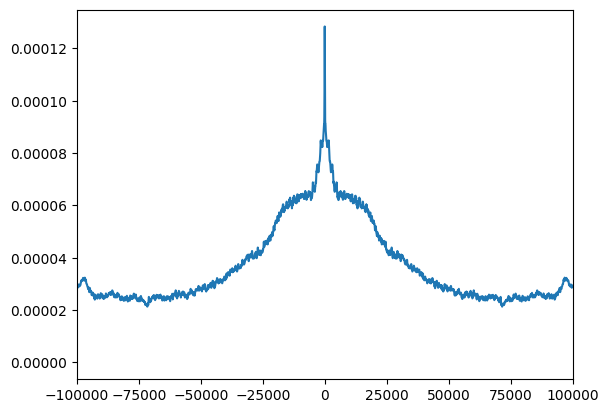

In [343]:
ac = fftconvolve(NH3_flux_uniform, NH3_flux_uniform[::-1], mode='full')
lags = np.arange(-len(NH3_flux_uniform)+1, len(NH3_flux_uniform))
plt.plot(lags, ac)
plt.xlim(-100000, 100000)
plt.show()

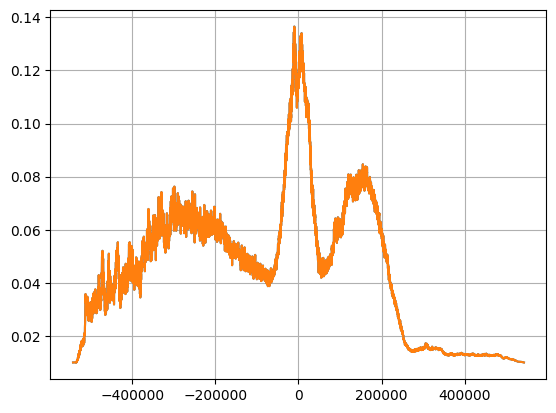

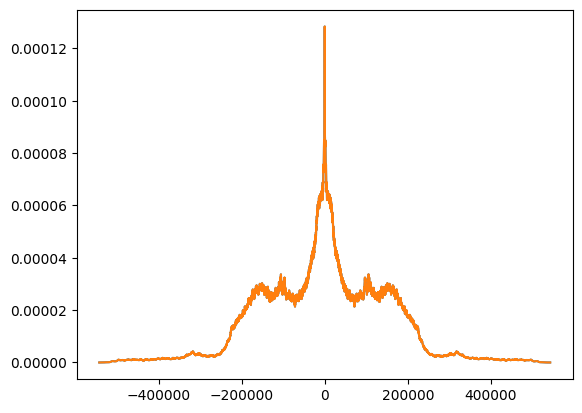

In [363]:
new_noise_flux = noise_flux_uniform.copy()
new_NH3_flux = NH3_flux_uniform.copy()
new_noise_wout_NH3_flux = noise_flux_wout_NH3_uniform.copy()

wl_mask = (wl_uniform < 6) | ((wl_uniform > 7) & (wl_uniform < 10)) | (wl_uniform > 15)
wl_mask = (wl_uniform < 3)
flux_treshold = 1

new_noise_flux[wl_mask] = 0
new_noise_flux[new_noise_flux>flux_treshold] = 0
# new_NH3_flux[wl_mask] = 0
# new_NH3_flux[new_NH3_flux>flux_treshold] = 0
new_noise_wout_NH3_flux[wl_mask] = 0
new_noise_wout_NH3_flux[new_noise_wout_NH3_flux>flux_treshold] = 0

cc_with = fftconvolve((new_NH3_flux), (new_noise_flux)[::-1], mode='full')
cc_without = fftconvolve((new_NH3_flux), (new_noise_wout_NH3_flux)[::-1], mode='full')
plt.plot(lags, cc_with+1e-2)
plt.plot(lags, cc_without+1e-2)
# plt.yscale('log')
plt.grid(True)
# plt.xlim(-100000, 100000)
plt.show()
plt.plot(lags, cc_with - cc_without)
plt.plot(lags, ac)
plt.show()

In [353]:
from scipy.optimize import minimize

def my_func(p):
    a,b,c = p
    new_noise_flux = noise_flux_uniform.copy()
    new_NH3_flux = NH3_flux_uniform.copy()
    new_noise_wout_NH3_flux = noise_flux_wout_NH3_uniform.copy()

    wl_mask = (wl_uniform < a) | (wl_uniform > b)
    flux_treshold = c

    new_noise_flux[wl_mask] = 0
    new_noise_flux[new_noise_flux>flux_treshold] = 0
    new_NH3_flux[wl_mask] = 0
    # new_NH3_flux[new_NH3_flux>flux_treshold] = 0
    new_noise_wout_NH3_flux[wl_mask] = 0
    new_noise_wout_NH3_flux[new_noise_wout_NH3_flux>flux_treshold] = 0

    cc_with = fftconvolve((new_NH3_flux), (new_noise_flux)[::-1], mode='full')
    cc_without = fftconvolve((new_NH3_flux), (new_noise_wout_NH3_flux)[::-1], mode='full')
    return -cc_with[lags==0]*4/np.trapezoid(lags, cc_with)

initial_guess = [7, 15, 0.1]  # choose sensible starting values

result = minimize(my_func, initial_guess, method='Nelder-Mead')  # or 'Powell', 'BFGS', etc.

best_params = result.x

[ 7.29324544 28.6661738   0.09648778]


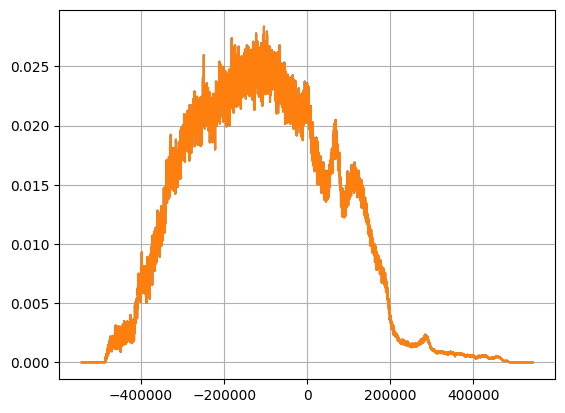

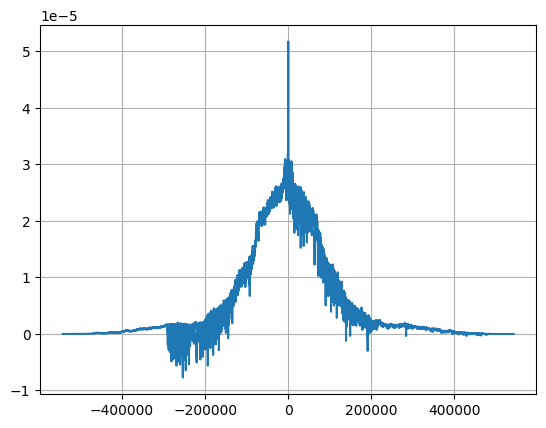

In [354]:
print(best_params)
new_noise_flux = noise_flux_uniform.copy()
new_NH3_flux = NH3_flux_uniform.copy()
new_noise_wout_NH3_flux = noise_flux_wout_NH3_uniform.copy()

wl_mask = (wl_uniform < best_params[0]) | (wl_uniform > best_params[1])
flux_treshold = best_params[2]

new_noise_flux[wl_mask] = 0
new_noise_flux[new_noise_flux>flux_treshold] = 0
new_NH3_flux[wl_mask] = 0
# new_NH3_flux[new_NH3_flux>flux_treshold] = 0
new_noise_wout_NH3_flux[wl_mask] = 0
new_noise_wout_NH3_flux[new_noise_wout_NH3_flux>flux_treshold] = 0

cc_with = fftconvolve((new_NH3_flux), (new_noise_flux)[::-1], mode='full')
cc_without = fftconvolve((new_NH3_flux), (new_noise_wout_NH3_flux)[::-1], mode='full')
plt.plot(lags, cc_with)
plt.plot(lags, cc_without)
plt.grid(True)
plt.show()
plt.plot(lags, cc_with - cc_without)
plt.grid(True)
plt.show()